--- Section 1: Loading Processed Data and Best Model ---
Data loaded successfully from C:\Users\nicol\OneDrive\Documentos\customer-churn-prediction\data\WA_Fn-UseC_-Telco-Customer-Churn.csv
Initial shape: (7043, 21)
Starting data cleaning...
Dropped 'customerID' column.
Converted 'TotalCharges' to numeric.
Filled missing 'TotalCharges' with median: 1397.475
Replaced 'No internet service' with 'No'.
Replaced 'No phone service' with 'No' in 'MultipleLines'.
Mapped 'Churn' target variable to 1/0.
Data cleaning complete.
Starting data preprocessing...
Preprocessing pipeline (ColumnTransformer) created.
Splitting data into training (80% and testing (20%) sets.
Original training set shape: (5634, 38), target shape: (5634,)
Original testing set shape: (1409, 38), target shape: (1409,)
Applying SMOTE to balance the training data...
Training data resampled with SMOTE. New shape: (8278, 38), target shape: (8278,)
Model loaded successfully from ../models/xgboost_churn_model.pkl
Successfully loade

c:\Users\nicol\OneDrive\Documentos\customer-churn-prediction\src\data_processor.py:76: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.df['TotalCharges'].fillna(median_total_charges, inplace=True)
C:\Users\nicol\AppData\Local\Temp\ipykernel_9884\3728173852.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(15), p

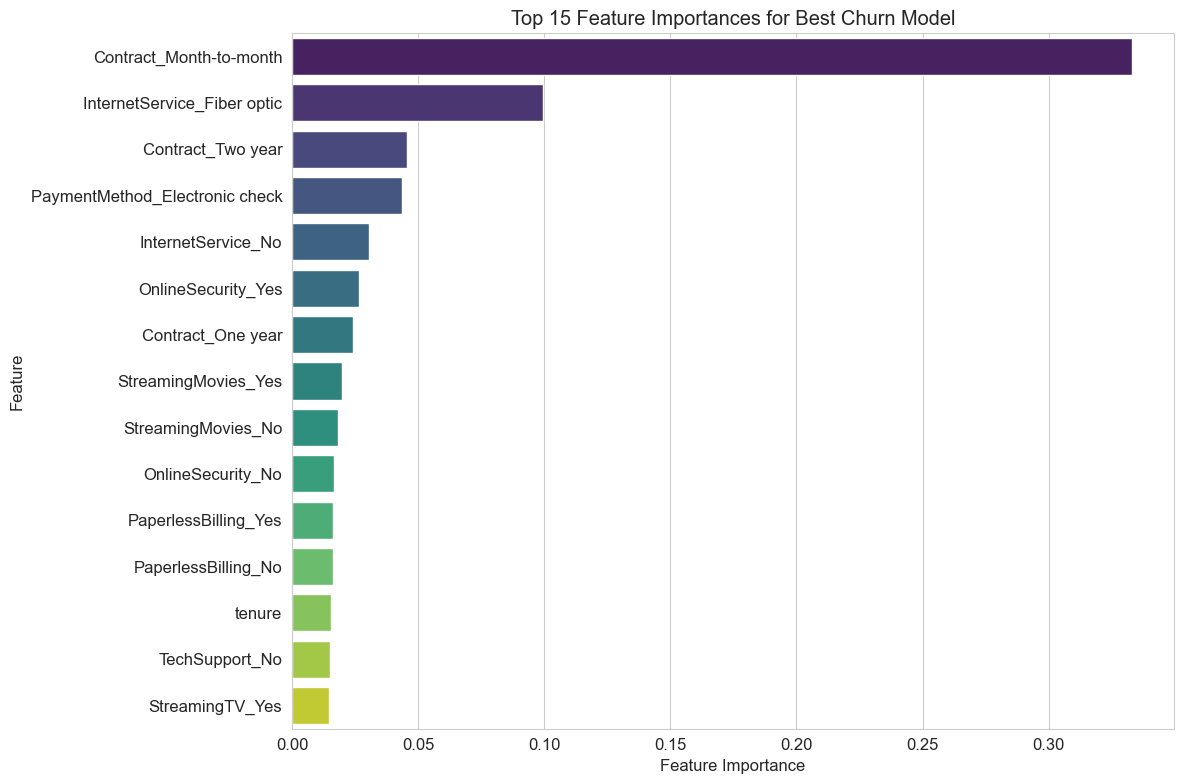


Analyzing churn rates for 'Month-to-month' contract:
Churn rate for 'Month-to-month' contract: 42.71%
Churn rate for other contract types: 6.76%

--- Section 3: Business Insights and Recommendations ---
Based on the EDA and feature importance analysis, here are some key insights and actionable recommendations:

**Key Insights:**
1.  **Contract Type is Critical:** 'Month-to-month' contracts are a primary driver of churn. Customers on these contracts have significantly higher churn rates compared to those on one-year or two-year contracts.
2.  **Lack of Security and Support:** Customers without 'OnlineSecurity', 'TechSupport', and 'DeviceProtection' are more prone to churn. These services likely contribute to a sense of security and reliability.
3.  **High Monthly Charges:** As 'MonthlyCharges' increase, so does the likelihood of churn, especially for customers without long-term commitments or bundled services.
4.  **Tenure Matters:** Newer customers (lower 'tenure') have a higher churn

In [4]:
# notebooks/04_insights_and_recommendations.ipynb

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # For loading models
import sys
import os

# Add the src directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../src')))

from data_processor import DataProcessor
from model_trainer import ModelTrainer

# Configure matplotlib and seaborn for better visuals
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# --- Section 1: Load Processed Data and Best Model ---
print("--- Section 1: Loading Processed Data and Best Model ---")

# Re-initialize DataProcessor to get feature names and preprocessor
processor = DataProcessor(data_path=r"C:\Users\nicol\OneDrive\Documentos\customer-churn-prediction\data\WA_Fn-UseC_-Telco-Customer-Churn.csv")
processor.load_data()
processor.clean_data()
processor.preprocess_data() # This sets up the preprocessor and identifies features

# Get processed data to evaluate the loaded model
X_train_processed, X_test_processed, y_train, y_test = processor.split_data(
    test_size=0.2, random_state=42, apply_smote=True
)

if X_test_processed is None:
    raise ValueError("Failed to load or preprocess data. Please check previous notebooks.")

# Initialize ModelTrainer (we won't train again, just use its load/interpret functions)
trainer = ModelTrainer(random_state=42)

# Assuming the best model is saved with a clear name (e.g., 'xgboost_churn_model.pkl')
# You'll need to know the name of your best model from the previous notebook.
# For example, if XGBoost was best:
model_name_for_loading = 'xgboost_churn_model.pkl' # <-- IMPORTANT: Update this based on your best model
model_path = f'../models/{model_name_for_loading}'

best_model = trainer.load_model(model_path)

if best_model is None:
    raise FileNotFoundError(f"Best model not found at {model_path}. Please ensure it was saved correctly in notebook 03.")

print(f"Successfully loaded the best model: {model_name_for_loading}")

# Get the feature names after preprocessing, which are essential for model interpretability
preprocessor = processor.get_preprocessor()
if preprocessor is None:
    raise ValueError("Preprocessor not available. Run processor.preprocess_data() correctly.")

# Get feature names from ColumnTransformer
# Numerical features directly keep their names
numerical_feature_names = processor.numerical_features
# Categorical features are one-hot encoded, so we need to get their new names
categorical_feature_names_out = preprocessor.named_transformers_['cat'].get_feature_names_out(processor.categorical_features).tolist()
processed_feature_names = numerical_feature_names + categorical_feature_names_out

print(f"Number of processed features: {len(processed_feature_names)}")

# --- Section 2: Model Interpretability - Feature Importance ---
print("\n--- Section 2: Model Interpretability - Feature Importance ---")

# Use the trainer's function to get and display feature importances
feature_importances_df = trainer.get_feature_importance(best_model, processed_feature_names)

if not feature_importances_df.empty:
    plt.figure(figsize=(12, 8))
    # Plotting based on whether it's importance (tree-based) or coefficient (linear)
    if 'Importance' in feature_importances_df.columns:
        sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(15), palette='viridis')
        plt.title('Top 15 Feature Importances for Best Churn Model')
        plt.xlabel('Feature Importance')
    elif 'Coefficient' in feature_importances_df.columns:
        # For linear models, plot absolute coefficients
        sns.barplot(x='Abs_Coefficient', y='Feature', data=feature_importances_df.head(15), palette='coolwarm')
        plt.title('Top 15 Feature Coefficients (Absolute Value) for Best Churn Model')
        plt.xlabel('Absolute Coefficient Value')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

# You can further analyze specific features here
# For example, investigate 'Contract_Month-to-month'
if 'Contract_Month-to-month' in processed_feature_names:
    original_df = processor.get_raw_data()
    if original_df is not None:
        print("\nAnalyzing churn rates for 'Month-to-month' contract:")
        monthly_contract_churn_rate = original_df[original_df['Contract'] == 'Month-to-month']['Churn'].mean()
        non_monthly_contract_churn_rate = original_df[original_df['Contract'] != 'Month-to-month']['Churn'].mean()
        print(f"Churn rate for 'Month-to-month' contract: {monthly_contract_churn_rate:.2%}")
        print(f"Churn rate for other contract types: {non_monthly_contract_churn_rate:.2%}")


# --- Section 3: Business Insights and Recommendations ---
print("\n--- Section 3: Business Insights and Recommendations ---")

print("Based on the EDA and feature importance analysis, here are some key insights and actionable recommendations:")

print("\n**Key Insights:**")
print("1.  **Contract Type is Critical:** 'Month-to-month' contracts are a primary driver of churn. Customers on these contracts have significantly higher churn rates compared to those on one-year or two-year contracts.")
print("2.  **Lack of Security and Support:** Customers without 'OnlineSecurity', 'TechSupport', and 'DeviceProtection' are more prone to churn. These services likely contribute to a sense of security and reliability.")
print("3.  **High Monthly Charges:** As 'MonthlyCharges' increase, so does the likelihood of churn, especially for customers without long-term commitments or bundled services.")
print("4.  **Tenure Matters:** Newer customers (lower 'tenure') have a higher churn risk. The risk decreases as tenure increases, indicating loyalty builds over time.")
print("5.  **Fiber Optic Service:** While offering high speeds, 'Fiber optic' internet service seems associated with higher churn, potentially due to service quality issues or higher expectations from customers.")
print("6.  **Senior Citizens:** Senior citizens appear to have a slightly higher churn rate, suggesting unique needs or pricing sensitivities for this demographic.")

print("\n**Actionable Recommendations for Customer Retention:**")
print("1.  **Promote Long-Term Contracts:** Develop aggressive marketing campaigns and incentives (e.g., discounts, free upgrades) to encourage month-to-month customers to switch to one-year or two-year contracts. Highlight savings and benefits of commitment.")
print("2.  **Bundle Security & Support Services:** Offer bundled packages that include 'OnlineSecurity', 'TechSupport', and 'DeviceProtection' at a subsidized rate or as a trial for at-risk customers. Emphasize peace of mind and hassle-free experience.")
print("3.  **Tiered Pricing & Value Communication:** Clearly communicate the value proposition for different price points. For customers with high monthly charges, offer loyalty discounts, personalized plans, or additional free services to prevent churn.")
print("4.  **Early Engagement & Onboarding:** Implement proactive outreach programs for new customers (especially within the first 3-6 months) to address any issues, ensure satisfaction, and highlight product benefits. A smooth onboarding experience can significantly reduce early churn.")
print("5.  **Address Fiber Optic Concerns:** Investigate potential issues with fiber optic service (e.g., unreliable connection, customer support for technical issues). Improve service quality and customer support for this segment.")
print("6.  **Targeted Campaigns for Senior Citizens:** Design specific plans, support options, or communication strategies tailored to the needs of senior citizens to enhance their satisfaction and reduce churn.")
print("7.  **Personalized Offers:** Utilize the churn prediction model to identify high-risk customers and offer personalized retention incentives (e.g., specific discounts, free premium channels, device upgrades) before they decide to leave.")

print("\n--- Section 4: Limitations and Future Work ---")
print("\n**Limitations:**")
print("1.  **Dataset Scope:** The dataset is synthetic and may not fully capture all real-world complexities or external factors influencing churn (e.g., competitor offerings, economic conditions).")
print("2.  **Feature Engineering:** Current features are derived directly from the dataset. More advanced feature engineering (e.g., customer usage patterns over time, sentiment analysis from call center logs) could improve model performance.")
print("3.  **Model Complexity:** While robust, more complex models or ensemble methods could be explored, but with careful consideration for interpretability.")
print("4.  **Cost of Misclassification:** The current evaluation focuses on standard metrics. A deeper analysis incorporating the financial costs of false positives (offering incentives to non-churners) versus false negatives (missing a churner) could refine strategy.")

print("\n**Future Work:**")
print("1.  **Time-Series Analysis:** Incorporate customer behavior over time (e.g., changes in monthly charges, usage patterns) for more dynamic predictions.")
print("2.  **Advanced Ensemble Methods:** Experiment with stacking or blending multiple models for potentially higher accuracy.")
print("3.  **A/B Testing Retention Strategies:** Once implemented, evaluate the effectiveness of retention strategies through controlled A/B tests.")
print("4.  **Deployment:** Deploy the best model as a service (e.g., using Flask/FastAPI) to allow real-time churn prediction for new or existing customers.")
print("5.  **Dashboarding:** Create an interactive dashboard (e.g., using Streamlit, Dash, Tableau) to visualize churn trends, model predictions, and impact of retention efforts.")

print("\nProject Analysis Complete.")
